<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_3_%D0%9E_%D0%B2%D0%BA%D1%83%D1%81%D0%BD%D0%BE%D0%B9_%D0%B8_%D0%B7%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D0%B8%D1%89%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Проект 3. О вкусной и здоровой пище

In [ ]:
import pandas as pd
 
path = 'https://raw.githubusercontent.com/akitim/datasets/main/main_task_new.csv'
rest = pd.read_csv(path)
  
# rest.columns = ['id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'rev_number', 'reviews', 'url_TA', 'id_TA']
rest.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


#Ответы на вопросы заданий

In [4]:
import pandas as pd
import numpy as np

RANDOM_SEED = 36

# rest.loc[0:100, 'reviews'].to_list()
path = 'https://raw.githubusercontent.com/akitim/datasets/main/main_task_new.csv'
rest = pd.read_csv(path)

rest.drop(['URL_TA', 'ID_TA'], axis=1, inplace=True)
rest.columns = ['id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'rev_number', 'reviews']

# 2.1 Задание 1
# Какие столбцы НЕ содержат пропущенных (None) значений?
# rest.info()
 
print('\nЕсть пропуски в столбцах:\n',
*list(rest.loc[:, rest.apply(pd.isna).any(axis=0)].columns))
 
print('\nНет пропусков в столбцах:\n',
*list(rest.loc[:, ~rest.apply(pd.isna).any(axis=0)].columns), '\n')
 
# 2.2 Задание 2
#rest.loc[0, :].apply(type) != str
 
# 2.3 Задание 3
#Приведение 'кухни' к списку
#rest.loc[0, 'Cuisine Style'].split(', ')
#[s.replace('[', '').replace(']', '').replace("'", "") for s in rest.loc[0, 'Cuisine Style'].s изplit(', ')]

# 4.1 Вопросы о ценах
rest.loc[:, 'price_range'].dropna().unique()
rest.loc[rest.loc[:, 'price_range'] == '$$ - $$$', 'price_range'].count()

# 4.2 Вопрос о городах
len(rest.loc[:, 'city'].unique())

# 4.3 Вопросы о кухнях
rest.loc[:, 'cuisine'] =\
rest.loc[:, 'cuisine'].fillna(value='[]').apply(
    lambda cuisine_list_for_id: \
    [s.replace("'", "") for s in cuisine_list_for_id[2:-2].split(', ')]
)

cuisine_list = []
for x in rest.loc[:, 'cuisine']:
    cuisine_list += x
cuisines_total = len(set(cuisine_list).difference(set([''])))
# cuisines_total = len(set(cuisine_list)) - 1

from collections import Counter
Counter(cuisine_list).most_common(1)[0][0]

round(
    rest.loc[:, 'cuisine'].apply(lambda x: len(x) if x != [] else 1).mean(),
    1
)

# 4.4 Вопросы об отзывах
import re
from datetime import datetime as dat

def rev_dates(s):
    date_regex = re.compile(r'(\d+/\d+/\d+)') # компилируем регулярку для поиска дат в формате dd/mm/YYYY
    str_date_ls = date_regex.findall(s)
    if str_date_ls != []:
        # str_date_ls = date_regex.findall(s)
        enum = list(enumerate(str_date_ls))
        # f = ['%m/%d/%Y' if int(str_date_ls[0][0:2].replace('/', '')) <= 12 else '%d/%m/%Y',
        #      '%m/%d/%Y' if int(str_date_ls[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y']
        f = ['%m/%d/%Y' if int(e[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y' for e in enum]
        return [dat.strptime(e[1], f[e[0]]) for e in enum] #dat.strptime(str_date_ls[0], f[0])
    else:
        return [dat(1970, 1, 1, 0, 0)] #strftime('%m/%d/%Y', '01/01/1970')

# когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
most_recent_rev_date =\
rest.loc[:, 'reviews'].apply(lambda s: rev_dates(s)[0]).max()
dat.strftime(most_recent_rev_date, '%Y-%m-%d') #->2018-02-26

# Какое максимальное количество дней отделяет даты публикации отзывов,
# размещённых на сайте ресторана? Введите количество дней в виде целого числа.
def last_rev_date_delta(dates):
    if len(dates) >= 3:
        return abs(dates[2] - dates[1]).days
    else:
        return abs(dates[0] - dates[-1]).days

# добавляем в данные столбец с кол-вом дней между двумя последними отзывами
rest.loc[:, 'delta'] =\
rest.loc[:, 'reviews'].apply(lambda s: last_rev_date_delta(rev_dates(s))) #.sort_values(ascending=False)
# rest['delta'].dt.days.astype(int).hist(log=True, bins=50);

#считаем кол-во кухонь в меню ресторана, добавляем соотв. столбец
rest.loc[:, 'n_of_cuisines'] = rest.loc[:, 'cuisine'].apply(lambda x: len(x) if x != [] else 1)
# rest.loc[:, 'n_of_cuisines'].hist(log=True, bins=50);

# добавляем столбец с населением города, в кот. находится ресторан
# rest.loc[:, 'city'].unique()
population = {'Paris': 2176, 'Stockholm': 1656, 'London': 10840, 'Berlin': 3664,
       'Munich': 1553, 'Oporto': 232, 'Milan': 3144, 'Bratislava': 433,
       'Vienna': 1911, 'Rome': 2860, 'Barcelona':1620, 'Madrid': 3223,
       'Dublin':555, 'Brussels': 1209, 'Zurich':415, 'Warsaw':1794,
       'Budapest': 1752, 'Copenhagen': 799, 'Amsterdam': 873, 'Lyon': 516,
       'Hamburg': 1899, 'Lisbon': 507, 'Prague': 1324, 'Oslo': 697, 
       'Helsinki': 658, 'Edinburgh':488, 'Geneva': 202, 'Ljubljana': 296,
       'Athens': 664, 'Luxembourg': 125, 'Krakow': 781}
rest.loc[:, 'population'] = rest.loc[:, 'city'].apply(lambda city: population[city])

# добавляем столбец с подушевым ВВП по ППС города, в кот. нах. ресторан
gdp = {
    'Paris': 61883, 'Stockholm': 61754, 'London': 58827, 'Berlin': 37601,
    'Munich': 69844, 'Oporto': 24819, 'Milan': 51768, 'Bratislava': 67841,
    'Vienna': 46787, 'Rome': 41475, 'Barcelona': 45752, 'Madrid': 43074,
    'Dublin':30000, 'Brussels': 54634, 'Zurich': 64302, 'Warsaw': 49722,
    'Budapest': 37399, 'Copenhagen': 54197, 'Amsterdam': 60857, 'Lyon': 46913,
    'Hamburg': 52947, 'Lisbon': 34782, 'Prague': 48160, 'Oslo': 64673,
    'Helsinki': 49760, 'Edinburgh': 44059, 'Geneva': 62115, 'Ljubljana': 39763,
    'Athens': 32167, 'Luxembourg': 88312, 'Krakow': 29695
}
rest.loc[:, 'gdp'] = rest.loc[:, 'city'].apply(lambda city: gdp[city])

#количество предприятий общепита в стране нахождения ресторана
n_of_food_serv = {
    'Paris': 161466, 'Stockholm': 23208, 'London': 88841, 'Berlin': 136091, 'Munich': 136091, 'Oporto': 31363,
       'Milan': 155875, 'Bratislava': 10917, 'Vienna': 27348, 'Rome': 155875, 'Barcelona': 72657, 'Madrid': 72657,
       'Dublin': 7993, 'Brussels': 30773, 'Zurich': 11961, 'Warsaw': 39291, 'Budapest': 16850, 'Copenhagen': 8983,
       'Amsterdam': 30502, 'Lyon': 161466, 'Hamburg': 136091, 'Lisbon': 31363, 'Prague': 45623, 'Oslo': 6605,
       'Helsinki': 7769, 'Edinburgh': 88841, 'Geneva': 11961, 'Ljubljana': 4369, 'Athens': 39978,
       'Luxembourg': 1475, 'Krakow': 39291
}
rest.loc[:, 'n_of_food_serv'] = rest.loc[:, 'city'].apply(lambda city: n_of_food_serv[city])

#получаем dummies из столбца cuisine и  прикрепляем его к осн. датафрейму 
# rest = pd.concat([
#          rest,
#          pd.get_dummies(rest.explode('cuisine'), columns=['cuisine'], prefix='').
#          sum(level=0).iloc[:, -cuisines_total:-1]],
#          axis=1
# )

#квантизуем признак price_range
#price_ranges = rest.loc[:, 'price_range'].dropna().unique()

price_range_quantize = {
    '$': 1, '$$ - $$$': 2, '$$$$': 3
}
rest.loc[:, 'price_range']=\
rest.loc[:, 'price_range'].apply(lambda x: 0 if pd.isna(x) else price_range_quantize[x])
rest.price_range

# Какие признаки возьмем в модель?
# ==================================
# ranking
# rev_number
# delta - кол-во дней между двумя последними отзывами +
# n_of_cuisines - кол-во кухонь, представленных в ресторане +
# population - население города, в котором расположен ресторан +
# gdp - подушевой ВВП по ППС города (USD)


Есть пропуски в столбцах:
 cuisine price_range rev_number

Нет пропусков в столбцах:
 id city ranking rating reviews 



0        2
1        0
2        3
3        0
4        2
        ..
39995    2
39996    2
39997    0
39998    2
39999    2
Name: price_range, Length: 40000, dtype: int64

#Заполнение пропусков

In [5]:
# pd.get_dummies(rest, columns=['Cuisine Style'])
# rest.loc[rest.loc[:, 'Cuisine Style'].apply(lambda r: pd.isna(r)), 'Cuisine Style']

#первый вариант заполнения пропусков в rev_number средним по всем ресторанам
# mean_NoR = rest.loc[:, 'rev_number'].mean()
# rest.loc[:, 'rev_number'] = \
# rest.loc[:, 'rev_number'].apply(lambda r: r if not(pd.isna(r)) else mean_NoR)

#второй вариант заполнения пропусков в rev_number средним по городу
mean_NoR_by_city = dict([
      (city, rest.loc[rest.loc[:, 'city'] == city, 'rev_number'].mean())\
      for city in rest.loc[:, 'city'].unique()
])

rest.loc[:, 'rev_number'].\
    fillna(rest.loc[:, 'city'].\
           apply(lambda c: mean_NoR_by_city[c]), inplace=True)

#Полиномиальные черты

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(
    rest.loc[:, ['n_of_cuisines', 'population', 'rev_number', 'ranking']]
             
)
# pd.DataFrame(poly_features).iloc[:, 1:9]
rest = pd.concat([
         rest,
         pd.DataFrame(poly_features) #.iloc[:, 1:9]
         ],
         axis=1
)
rest
# rest.loc[:, 'city'].unique()
# pd.get_dummies(rest.explode('cuisine'), columns=['cuisine'], prefix='').\
#          sum(level=0).iloc[:, -125:-1]
# rest.explode('cuisine')

,id,city,cuisine,ranking,rating,price_range,rev_number,reviews,delta,n_of_cuisines,population,gdp,n_of_food_serv,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",41,3,2176,61883,161466,1.0,3.0,2176.0,194.0,5570.0,9.0,6528.0,582.0,16710.0,4734976.0,422144.0,12120320.0,37636.0,1080580.0,31024900.0
1,id_1535,Stockholm,[],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",382,1,1656,61754,23208,1.0,1.0,1656.0,10.0,1537.0,1.0,1656.0,10.0,1537.0,2742336.0,16560.0,2545272.0,100.0,15370.0,2362369.0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",2,7,10840,58827,88841,1.0,7.0,10840.0,688.0,353.0,49.0,75880.0,4816.0,2471.0,117505600.0,7457920.0,3826520.0,473344.0,242864.0,124609.0
3,id_3456,Berlin,[],3458.0,5.0,NaN,3.0,"[[], []]",0,1,3664,37601,136091,1.0,1.0,3664.0,3.0,3458.0,1.0,3664.0,3.0,3458.0,13424896.0,10992.0,12670112.0,9.0,10374.0,11957764.0
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",272,3,1553,69844,136091,1.0,3.0,1553.0,84.0,621.0,9.0,4659.0,252.0,1863.0,2411809.0,130452.0,964413.0,7056.0,52164.0,385641.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",34,4,3144,51768,155875,1.0,4.0,3144.0,79.0,500.0,16.0,12576.0,316.0,2000.0,9884736.0,248376.0,1572000.0,6241.0,39500.0,250000.0
39996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",9,5,2176,61883,161466,1.0,5.0,2176.0,542.0,6341.0,25.0,10880.0,2710.0,31705.0,4734976.0,1179392.0,13798016.0,293764.0,3436822.0,40208281.0
39997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",3127,2,1656,61754,23208,1.0,2.0,1656.0,4.0,1652.0,4.0,3312.0,8.0,3304.0,2742336.0,6624.0,2735712.0,16.0,6608.0,2729104.0
39998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",23,5,1794,49722,39291,1.0,5.0,1794.0,70.0,641.0,25.0,8970.0,350.0,3205.0,3218436.0,125580.0,1149954.0,4900.0,44870.0,410881.0


#Черновик 1

In [ ]:
# import re
# from datetime import datetime as dat

# date_regex.findall(s)[0][0:2] <\
# date_regex.findall(s)[0][3:5] #->11 #->18

st = "[['Best place to try a Bavarian food', 'Nice building but improvements need to be...'], ['11/18/2017', '02/19/2017']]"
# rev_date(s)
# date_regex = re.compile(r'(\d+/\d+/\d+)') # компилируем регулярку для поиска дат в формате dd/mm/YYYY
# str_date_ls = date_regex.findall(st)

# r

# rev_dates(st)
# str_date_ls, f, enum

# se = rest.loc[:, 'reviews'].apply(lambda s: len(rev_dates(s)))
# rest[se==1]['reviews']
# rest.loc[[9254, 23348], 'reviews'].to_list()
# rest.loc[rest.loc[:, 'reviews'].apply(lambda s: ("'], ['" in s) or (s == "[[], []]")), 'reviews'].index.to_list()
# se = rest.loc[:, 'reviews'].apply(lambda s: s.count('['))
# rest[se!=3]['reviews'].to_list()

se = rest.loc[:, 'reviews'].apply(lambda s: len(rev_dates(s)))
rest[se==1]['reviews']
rest.loc[[9254, 23348], 'reviews'].to_list()
rest.loc[rest.loc[:, 'reviews'].apply(lambda s: ("'], ['" in s) or (s == "[[], []]")), 'reviews'].index.to_list()
se = rest.loc[:, 'reviews'].apply(lambda s: s.count('['))
rest[se!=3]['reviews'].to_list()

["[['Good food, attentive staff', 'Sternstraße 125, Schanzenviertel, [59], ju...'], ['05/10/2015', '07/05/2014']]",
 "[['Nice lunch for a hungry group[ of travelle...', 'Tasty salad and sandwich'], ['10/24/2017', '01/12/2017']]",
 "[['Veramente Italiano [Really Italian]', 'Lunch on a Sunday'], ['12/11/2017', '11/19/2017']]"]

In [ ]:
#Предобработка
# rest.loc[0, :].apply(type)
# rest.dropna(axis=0, inplace=True)

rest.loc[:, 'cuisine'] =\
rest.loc[:, 'cuisine'].apply(
    lambda cuisine_list_for_id: \
        [s.replace("'", "") for s in cuisine_list_for_id[2:-2].split(', ')]\
            if not(pd.isna(cuisine_list_for_id)) else []
)

            # rest.loc[0, 'Cuisine Style'][0]
            # rest.get_dummies()
# rest

,id,city,cuisine,ranking,rating,price_range,rev_number,reviews,url_TA,id_TA
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,[],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,[],3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414
39996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036
39997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615
39998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838


In [ ]:
# rest.loc[:, 'n_of_cuisines']



#Данные в модель

In [8]:
# rest_m = rest.loc[:, ['ranking', 'rev_number', 'n_of_cuisines', 'delta', 'population']]
rest_m = rest.drop(['id', 'city', 'cuisine', 'rating',  'reviews'],
                   axis=1)
rest_m

,ranking,price_range,rev_number,delta,n_of_cuisines,population,gdp,n_of_food_serv
0,5570.0,2,194.0,41,3,2176,61883,161466
1,1537.0,0,10.0,382,1,1656,61754,23208
2,353.0,3,688.0,2,7,10840,58827,88841
3,3458.0,0,3.0,0,1,3664,37601,136091
4,621.0,2,84.0,272,3,1553,69844,136091
...,...,...,...,...,...,...,...,...
39995,500.0,2,79.0,34,4,3144,51768,155875
39996,6341.0,2,542.0,9,5,2176,61883,161466
39997,1652.0,0,4.0,3127,2,1656,61754,23208
39998,641.0,2,70.0,23,5,1794,49722,39291


# Создаём, обучаем и тестируем модель

MAE: 0.181875


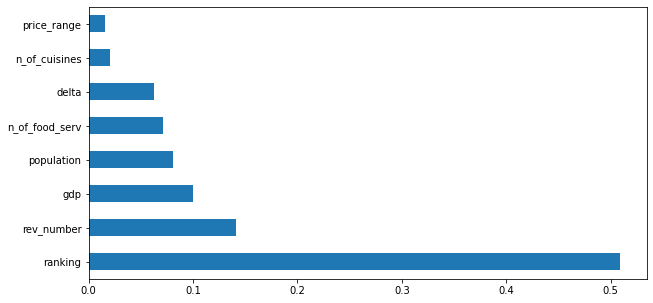

In [9]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = rest.drop(['Restaurant_id', 'Rating'], axis = 1)  
X = rest_m
y = rest.loc[:, 'rating']
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
    # Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
# Импортируем необходимые библиотеки:  
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=1, random_state=RANDOM_SEED)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

y_pred = (y_pred*2).round()/2
 
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

plt.rcParams['figure.figsize'] = (10, 5)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(22).plot(kind='barh');